**==== 1 - Data import and pre-processing ====**

In [2]:
# dwonload and unzip dataset
!wget https://files.consumerfinance.gov/ccdb/complaints.csv.zip
!unzip /content/complaints.csv.zip -d /content/complaints.csv
# install NLTK
!pip install nltk

--2022-05-28 07:37:10--  https://files.consumerfinance.gov/ccdb/complaints.csv.zip
Resolving files.consumerfinance.gov (files.consumerfinance.gov)... 108.159.227.5, 108.159.227.104, 108.159.227.98, ...
Connecting to files.consumerfinance.gov (files.consumerfinance.gov)|108.159.227.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443784008 (423M) [binary/octet-stream]
Saving to: ‘complaints.csv.zip.1’

complaints.csv.zip. 100%[===================>] 423.22M   209MB/s    in 2.0s    

2022-05-28 07:37:12 (209 MB/s) - ‘complaints.csv.zip.1’ saved [443784008/443784008]

Archive:  /content/complaints.csv.zip
replace /content/complaints.csv/complaints.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/complaints.csv/complaints.csv  


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO

from nltk.stem.snowball import SnowballStemmer

from IPython.display import display

In [4]:
# load data into a pandas dataframe from csv file
df = pd.read_csv("/content/complaints.csv/complaints.csv",low_memory=False)
df.shape

(2693834, 18)

In [5]:
# seperate Product & Consumer Complaints columns from initial dataframe
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [6]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1119247
Debt collection                                                                  425150
Mortgage                                                                         354535
Credit card or prepaid card                                                      145184
Credit reporting                                                                 140430
Checking or savings account                                                      123369
Credit card                                                                       89190
Bank account or service                                                           86206
Student loan                                                                      67011
Money transfer, virtual currency, or money service                                40671
Vehicle loan or lease                                                             33068
Consumer Loan                   

In [7]:
# check null values on complaints
df.isnull().sum()

Product                               0
Consumer complaint narrative    1750971
dtype: int64

In [8]:
# keep only 'not null' complaints rows
df = df[pd.notnull(df['Consumer complaint narrative'])] 
df.shape

(942863, 2)

In [9]:
# since the dataset is imbalanced
# remove products with complaints < 10,000
# remove products with complaints > 100,000 
counts = df['Product'].value_counts()
df = df[~df['Product'].isin(counts[counts < 10000].index)]
df = df[~df['Product'].isin(counts[counts > 100000].index)]
df.shape

(357009, 2)

In [10]:
df['Product'].value_counts()

Mortgage                                              91969
Credit card or prepaid card                           71415
Checking or savings account                           45394
Credit reporting                                      31588
Student loan                                          30813
Money transfer, virtual currency, or money service    22485
Credit card                                           18838
Vehicle loan or lease                                 17640
Bank account or service                               14885
Payday loan, title loan, or personal loan             11982
Name: Product, dtype: int64

In [11]:
# remove duplicated rows in dataframe
df = df.drop_duplicates(keep="first")
df.shape

(353019, 2)

In [12]:
df['Product'].value_counts()

Mortgage                                              91837
Credit card or prepaid card                           70241
Checking or savings account                           45341
Student loan                                          30670
Credit reporting                                      29827
Money transfer, virtual currency, or money service    22199
Credit card                                           18757
Vehicle loan or lease                                 17357
Bank account or service                               14856
Payday loan, title loan, or personal loan             11934
Name: Product, dtype: int64

In [13]:
# overwrite colum names into 'Product' & 'Consumer_Complaint'
df.columns = ['Product', 'Consumer_Complaint']
df

,Product,Consumer_Complaint
54,Credit card or prepaid card,"Please reopen case XXXX, Nothing has been reso..."
108,Credit card or prepaid card,This was not sent is error i am a consumer by ...
125,Credit card or prepaid card,I bought 2 {$100.00} XXXX gift cards at XXXX a...
138,Vehicle loan or lease,Sun coast credit union committed insurance fra...
147,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...
...,...,...
2693824,Credit card,A reward coupon from XXXX expired and American...
2693826,Credit reporting,Wrong name no XXXX XXXX XXXX and wrong address...
2693828,Credit card,"Automated calls from "" XXXX with Capital One '..."
2693830,Mortgage,My father died in XX/XX/XXXX. Left me his only...


In [14]:
# convert complaints data into lowercase
# tf-idf cares very much whether words are capitalized or not. 
# They're different words as far as the algorithm can tell. This is why normalization (lower-casing in this case) is so important.
# df["Consumer_Complaint"] = df["Consumer_Complaint"].str.lower()
# df

In [15]:
np.random.seed(10)
remove_n = 200000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)
df.shape

(153019, 2)

In [16]:
# manually add specific id to each product type
# cid={'Credit reporting':0, 'Student loan':1, 'Mortgage':2, 'Debt collection':3, 'Vehicle loan or lease':4, 'Credit card or prepaid card':5, 'Checking or savings account':6, 'Money transfer, virtual currency, or money service':7, 'Credit card':8, 'Payday loan, title loan, or personal loan':9, 'Bank account or service':10}
# df['cid']=df['Product'].map(cid)
df['cid'] = df['Product'].factorize()[0]
df

,Product,Consumer_Complaint,cid
125,Credit card or prepaid card,I bought 2 {$100.00} XXXX gift cards at XXXX a...,0
147,Vehicle loan or lease,Kia Finance is showing I have a {$10.00} curre...,1
200,Checking or savings account,Banking services or operating as expected. Sun...,2
246,Student loan,I have Direct Consolidated loans serviced by F...,3
289,Mortgage,I can prove that XXXX XXXX lied about my inten...,4
...,...,...,...
2693820,Student loan,"Insanely high monthly payments, with "" no opti...",3
2693822,Mortgage,Caliber Home Loans ( CHL ) sent confirmation i...,4
2693828,Credit card,"Automated calls from "" XXXX with Capital One '...",8
2693830,Mortgage,My father died in XX/XX/XXXX. Left me his only...,4


In [17]:
df['Product'].value_counts()

Mortgage                                              39616
Credit card or prepaid card                           30565
Checking or savings account                           19622
Student loan                                          13294
Credit reporting                                      12984
Money transfer, virtual currency, or money service     9627
Credit card                                            8160
Vehicle loan or lease                                  7563
Bank account or service                                6431
Payday loan, title loan, or personal loan              5157
Name: Product, dtype: int64

In [18]:
# Text Preprocessing using NLTK
# function definition for stemming, tokenizing, removing stop words and 'XX' values from complaint strings using NLTK
# this will be used on TfidfVectorizer
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
def wordTokenizer(text):
   # tokenize words using nltk word_tokenize operation and remove unnecessary characters
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   # convert complaints data into lowercase
   # tf-idf consider same word in different case (lowercase/uppercase/camelcase/mixed) formats as different words. 
   tokens = map(str.lower, tokens)
   # stem and return tokens that are not in stop words list
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


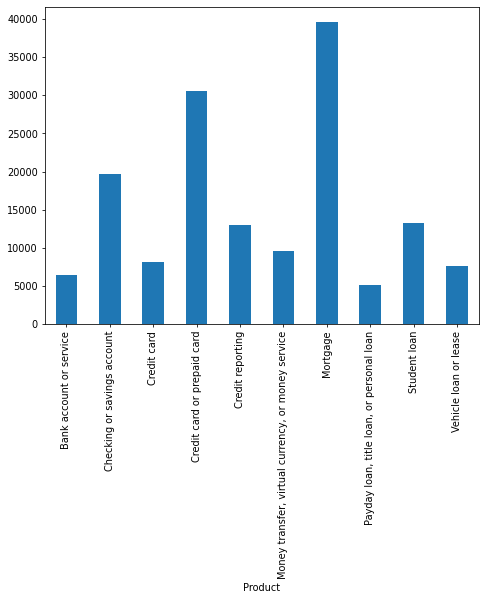

In [19]:
# data distribution among selected product classes
fig = plt.figure(figsize=(8,6),dpi=70.0)
df.groupby('Product').Consumer_Complaint.count().plot.bar(ylim=0)
plt.show()

==== 2. Creating Feature Vector ====

In [20]:
# dataframe to map product - category_id 
category_id_df = df[['Product', 'cid']].drop_duplicates().sort_values('cid')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['cid', 'Product']].values)

In [21]:
nltk.download('punkt')
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.75, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=None, lowercase=False, max_features=1000, tokenizer=wordTokenizer)
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=None, lowercase=False, max_features=1000, tokenizer=wordTokenizer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
features = tfidf.fit_transform(df.Consumer_Complaint).toarray()
labels = df.cid
features.shape

(153019, 1000)

In [23]:
N = 2
for Product, cid in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == cid)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [item for item in feature_names if len(item.split(' ')) == 1]
  bigrams = [item for item in feature_names if len(item.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. deposit
. overdraft
  . Most correlated bigrams:
. check account
. overdraft fee
# 'Checking or savings account':
  . Most correlated unigrams:
. branch
. deposit
  . Most correlated bigrams:
. save account
. check account
# 'Credit card':
  . Most correlated unigrams:
. credit
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. loan
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. experian
. equifax
  . Most correlated bigrams:
. credit file
. credit report
# 'Money transfer, virtual currency, or money service':
  . Most correlated unigrams:
. paypal
. coinbas
  . Most correlated bigrams:
. bank account
. money back
# 'Mortgage':
  . Most correlated unigrams:
. modif
. mortgag
  . Most correlated bigrams:
. mortgag payment
. mortgag compani
# 'Payday loan, title loan, or 

**==== 3. Train, Test and Compare Different ML Models ====**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_Complaint'], df['Product'], random_state = 0, test_size=0.2)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [25]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Credit reporting']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


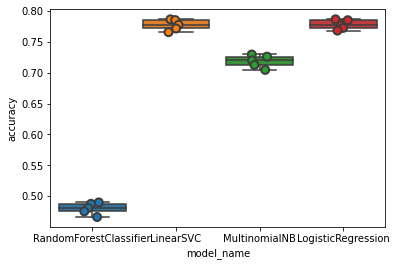

In [26]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(max_iter=2000),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [27]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.777230
LogisticRegression        0.777753
MultinomialNB             0.718434
RandomForestClassifier    0.479901
Name: accuracy, dtype: float64

**==== 4. Evaluating the performance of the LinearSVC model with performance metrics ====**

from above comparision , we have selected Linear Support Vector Classifier model 

In [58]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [30]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . mile
  . Top bigrams:
       . credit union
       . bank america
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . account
  . Top bigrams:
       . credit union
       . debit card
# 'Credit card':
  . Top unigrams:
       . card
       . discov
  . Top bigrams:
       . mortgag loan
       . credit card
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . synchroni
  . Top bigrams:
       . credit union
       . credit limit
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . transunion
  . Top bigrams:
       . mortgag loan
       . loan modif
# 'Money transfer, virtual currency, or money service':
  . Top unigrams:
       . coinbas
       . paypal
  . Top bigrams:
       . credit card
       . mortgag loan
# 'Mortgage':
  . Top unigrams:
       . mortgag
       . loancar
  . Top bigrams:
       . loan offic
       . home loan
# 'Payday loan, title loan, 

== **Accuracy of the model** ==

In [61]:
#Deriving the accuracy of the model using the predefined function in sklearn library
model_accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Model Accuracy : {model_accuracy}")

Model Accuracy : 0.7786205121096302



  **== Precision of the model** (Calculate precision of this multi class classification through )  ==

*    **Macro averaged precision**: calculate precision for all classes individually and then average them
*    **Micro averaged precision**: calculate class wise true positive and false positive and then use that to calculate overall precision

In [60]:
#Deriving the Macro & Micro precision of the model using the predefined function in sklearn library
macro_averaged_precision = metrics.precision_score(y_test, y_pred, average = 'macro')
micro_averaged_precision = metrics.precision_score(y_test, y_pred, average = 'micro')

print(f"Macro-Averaged Precision score : {macro_averaged_precision}")
print(f"Micro-Averaged Precision score : {micro_averaged_precision}")

Macro-Averaged Precision score : 0.6981664565902002
Micro-Averaged Precision score : 0.7786205121096302



   == **Recall of the model** (Calculate recall of this multi class classification through) ==

*    **Macro averaged recall** : calculate recall for all classes individually and then average them
*    **Micro averaged recall** : calculate class wise true positive and false negative and then use that to calculate overall recall

In [62]:
micro_averaged_recall = metrics.recall_score(y_test, y_pred, average = 'micro')
macro_averaged_recall = metrics.recall_score(y_test, y_pred, average = 'macro')
print(f"Micro-Averaged recall score : {micro_averaged_recall}")
print(f"Macro-averaged recall score : {macro_averaged_recall}")

Micro-Averaged recall score : 0.7786205121096302
Macro-averaged recall score : 0.6423995633329361


== **F1 Score** (To compute F1 Score of this multi class classification problem) ==


*  **Macro averaged F1 Score**: calculate f1 score of every class and then average them
* **Micro averaged F1 Score**: calculate macro-averaged precision score and macro-averaged recall score and then take there harmonic mean





In [63]:
macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
micro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'micro')
print(f"Macro-Averaged F1 score : {macro_averaged_f1}")
print(f"Micro-Averaged F1 score : {micro_averaged_f1}")

Macro-Averaged F1 score : 0.638516228691067
Micro-Averaged F1 score : 0.7786205121096302


== **Area under the ROC (Receiver Operating Characteristic) curve** ==

In [51]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [52]:
roc_auc_dict = roc_auc_score_multiclass(y_test, y_pred)
roc_auc_dict

{0: 0.8829309502950762,
 1: 0.8547962268998123,
 2: 0.8644939995320264,
 3: 0.9468515774436892,
 4: 0.9663045421412788,
 5: 0.8417191516376373,
 6: 0.7465920645038931,
 7: 0.9304516738154908,
 8: 0.51407484927918,
 9: 0.5333991382779532}

== **Confusion Matrix** == 

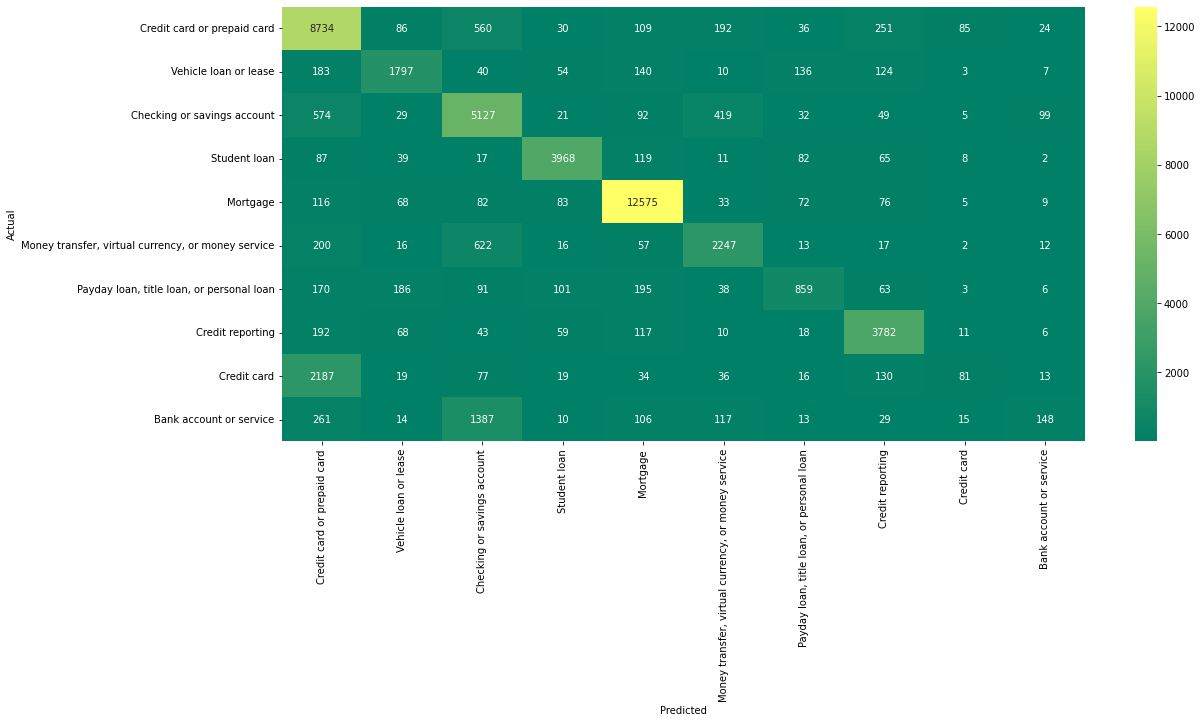

In [57]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(18,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values, cmap = 'summer')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

== **Model Evaluation Summary** == 

In [36]:
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                    precision    recall  f1-score   support

                       Credit card or prepaid card       0.69      0.86      0.77     10107
                             Vehicle loan or lease       0.77      0.72      0.75      2494
                       Checking or savings account       0.64      0.80      0.71      6447
                                      Student loan       0.91      0.90      0.91      4398
                                          Mortgage       0.93      0.96      0.94     13119
Money transfer, virtual currency, or money service       0.72      0.70      0.71      3202
         Payday loan, title loan, or personal loan       0.67      0.50      0.57      1712
                                  Credit reporting       0.82      0.88      0.85      4306
                                       Credit card       0.37      0.03      0.06      2612
                           Bank account or service       0.45      0.07      0.

== **Summay of incorrect predictions** ==

In [64]:
for predicted in category_id_df.cid:
  for actual in category_id_df.cid:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_Complaint']])
      print('')

'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 183 examples.


,Product,Consumer_Complaint
1624509,Vehicle loan or lease,I had a lease with Hyundai Capital America. I ...
2572590,Vehicle loan or lease,Our lease on our GMC XXXX completed in XX/XX/X...
411152,Vehicle loan or lease,I was shocked when I reviewed my credit report...
443140,Vehicle loan or lease,This particular account situation that is late...
2270244,Vehicle loan or lease,"During XXXX of 2017, my wife scheduled but fai..."
...,...,...
1308085,Vehicle loan or lease,I was interested in possibly purchasing a XXXX...
2648198,Vehicle loan or lease,I would like to report unethical business prac...
2211054,Vehicle loan or lease,I have a loan with SANTANDER. I have always ma...
2326092,Vehicle loan or lease,On XXXX XXXX I have contacted CAPITAL ONE to i...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 574 examples.


,Product,Consumer_Complaint
2479733,Checking or savings account,I dont own a PNC account. I have a prepaid car...
1924182,Checking or savings account,On XX/XX/2021 I payed a credit card bill to Fi...
123854,Checking or savings account,My card was stolen after I made a purchase at ...
576058,Checking or savings account,PNC stopped allowing customers to manage their...
1244172,Checking or savings account,I was told that they would do the trade then f...
...,...,...
1034138,Checking or savings account,I reached out to citi for some via XXXX for so...
215556,Checking or savings account,Chase bank is closing my private client accoun...
384662,Checking or savings account,Timeline : XX/XX/19 payment of {$160.00} made ...
1600692,Checking or savings account,"Bank of America, XXXX XXXX, Florida has placed..."



'Student loan' predicted as 'Credit card or prepaid card' : 87 examples.


,Product,Consumer_Complaint
2488834,Student loan,Heartland ECSI has me set up for quarterly pay...
1465417,Student loan,I've seen no changes for the accounts that I h...
2329116,Student loan,"This is XXXX XXXX XXXX, who is submitting this..."
2052248,Student loan,My brother has assumed responsibility for payi...
2326248,Student loan,"Dear Sir or Madam, 1. XXXX/NAVIENT Account Num..."
...,...,...
2641942,Student loan,Called on XX/XX/XXXX to tell Sallie Mae that I...
1513237,Student loan,I've seen no changes for the accounts that I h...
257892,Student loan,General revenue services has been harassing me...
2034462,Student loan,Higher interest rate charged than originally t...



'Mortgage' predicted as 'Credit card or prepaid card' : 116 examples.


,Product,Consumer_Complaint
2412525,Mortgage,"PLEASE NOTE, THIS IS NOT A REPEAT-ITS A NEW CO..."
1074709,Mortgage,"On XXXX/XXXX/16, I ordered a billpay payment f..."
1963174,Mortgage,Bank of America hit me for a missed payment ba...
1990528,Mortgage,Flagstar Bank is reporting a 30 day late payme...
1871247,Mortgage,"As of XX/XX/XXXX, I had not received my NewRez..."
...,...,...
1268254,Mortgage,I made a payment on XX/XX/XXXX which was not a...
1338133,Mortgage,I applied for a cash out refi on one of the pr...
624631,Mortgage,I called and tried to pay and they refuse to t...
2151914,Mortgage,We were charged twice for the month of XX/XX/X...



'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 200 examples.


,Product,Consumer_Complaint
2282915,"Money transfer, virtual currency, or money ser...",Someone hack into my edd card and took out my ...
2280920,"Money transfer, virtual currency, or money ser...",I sent a check for a total of {$7500.00} on XX...
2576853,"Money transfer, virtual currency, or money ser...",Apple Card cant verify my identity through XXX...
1504825,"Money transfer, virtual currency, or money ser...",VERY BAD PEOPLE 'S PHONE XXXX CALLED XXXX/XXXX...
2363828,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, an unauthorized payment was cha..."
...,...,...
223962,"Money transfer, virtual currency, or money ser...","To whom it may concern, On XX/XX/2019 I paid a..."
2255247,"Money transfer, virtual currency, or money ser...",In yet another XXXX occurrence from the compan...
70268,"Money transfer, virtual currency, or money ser...","I have a Crypto.com Account, with a XXXX card...."
2198191,"Money transfer, virtual currency, or money ser...",Dear XXXX XXXX Senior Customer Care Specialist...



'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 170 examples.


,Product,Consumer_Complaint
336052,"Payday loan, title loan, or personal loan",This company charged off/sent my account to an...
893582,"Payday loan, title loan, or personal loan",This particular account situation that is late...
371940,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I scheduled an ACH payment of {$...
2433410,"Payday loan, title loan, or personal loan",As of XX/XX/2019 Oportun has negatively impact...
2474424,"Payday loan, title loan, or personal loan",Discover bank decreasing my credit limit from ...
...,...,...
1758460,"Payday loan, title loan, or personal loan",I have been contacting XXXX XXXX XXXX XXXX Cre...
466904,"Payday loan, title loan, or personal loan",Aquired a loan from Fortiva. I made a payment ...
514545,"Payday loan, title loan, or personal loan",AMERICASH continues to allow their 3rd party v...
1228938,"Payday loan, title loan, or personal loan",Pnc wont let me connect to XXXX. XXXX chat is...



'Credit reporting' predicted as 'Credit card or prepaid card' : 192 examples.


,Product,Consumer_Complaint
1991323,Credit reporting,"I have a credit card with XXXX XXXX XXXX, whic..."
1353915,Credit reporting,I received my credit report XX/XX/XXXX because...
2664877,Credit reporting,I 'm a victim of identity theft and some XXXX ...
1847881,Credit reporting,The account XXXX that 's reporting on credit i...
2413132,Credit reporting,"On XXXX XXXX, 2015 I attempted to purchase a 3..."
...,...,...
1350196,Credit reporting,I have a civil action that 's incorrect been r...
2661719,Credit reporting,"Remove XXXX Bank that is open on XXXX XXXX, XX..."
2004622,Credit reporting,"Hello, I lived almost all my life outside of t..."
758537,Credit reporting,I tried to cash my WV XXXX tax refund ( {$97.0...



'Credit card' predicted as 'Credit card or prepaid card' : 2187 examples.


,Product,Consumer_Complaint
771254,Credit card,Synchrony bank card ( carecredit ) website is ...
2043593,Credit card,CITIBANK XXXX Mastercard : My terms and condit...
1327431,Credit card,My credit card experienced unauthorized charge...
1325513,Credit card,Someone was able to hack into my Kohl 's charg...
791267,Credit card,I am XXXX XXXX military currently XXXX. I XXXX...
...,...,...
1930521,Credit card,I applied for a XXXX XXXX Credit card which is...
2060417,Credit card,I HAVE A COMPLAINT WITH WELLS FARGO ( XXXX XXX...
804166,Credit card,On our Barclaycard we had a balance of XXXX. W...
1011686,Credit card,We are very careful with any charges on credit...



'Bank account or service' predicted as 'Credit card or prepaid card' : 261 examples.


,Product,Consumer_Complaint
910932,Bank account or service,Wells Fargo prematurely closed my account desp...
903636,Bank account or service,"On Saturday, XXXX XXXX, 2015 I contact Navy Fe..."
493722,Bank account or service,"In conclusion, one online bank rep cost me a l..."
2663630,Bank account or service,"XXXX XXXX XXXX XXXX, SC XXXX : Capital One FCR..."
2660971,Bank account or service,This is the XXXX complaint that I have filed a...
...,...,...
2659151,Bank account or service,Taking an offer with Bloomingdales to receive ...
1955118,Bank account or service,"I received an amazon.com store card, issued by..."
1284890,Bank account or service,"My checking account with Huntington Bank, # XX..."
1949732,Bank account or service,I have three promotional offer accounts with S...



'Credit card or prepaid card' predicted as 'Vehicle loan or lease' : 86 examples.


,Product,Consumer_Complaint
2277795,Credit card or prepaid card,I had leased office space because of a contrac...
2266407,Credit card or prepaid card,"On XX/XX/2018, I received a letter from US Ban..."
1985857,Credit card or prepaid card,"Unfortunately, at the time of the incident men..."
997069,Credit card or prepaid card,I arranged auto payments thru Kohl 's credit a...
1644766,Credit card or prepaid card,I have a loan with Alliant Credit Union. I hav...
...,...,...
2288941,Credit card or prepaid card,Hello this is XXXX XXXX with current address a...
639185,Credit card or prepaid card,"I paid to Macy 's {$21.00} back on XX/XX/2019,..."
1222218,Credit card or prepaid card,i fell behind on my payments due to some perso...
884963,Credit card or prepaid card,I have called twice today to make a payment an...



'Checking or savings account' predicted as 'Vehicle loan or lease' : 29 examples.


,Product,Consumer_Complaint
474879,Checking or savings account,This very important and there is so much more ...
119030,Checking or savings account,The complainant was fraudulently charged ( {$1...
689644,Checking or savings account,In XX/XX/2018 I purchased a {$500.00} gift car...
1488938,Checking or savings account,I have paid my auto insurance for nine months ...
2506360,Checking or savings account,"XX/XX/2022, I called to make some corrections ..."
2406731,Checking or savings account,I recently applied for an auto loan through Ba...
359577,Checking or savings account,Company violated my rights by law. By reportin...
968980,Checking or savings account,I have an AUTO Policy with USAA. My vehicle wa...
1783552,Checking or savings account,A credit in the amount of XXXX was issued from...
2502050,Checking or savings account,Hello. \n\nFor context I bank with Chase and m...



'Student loan' predicted as 'Vehicle loan or lease' : 39 examples.


,Product,Consumer_Complaint
2299177,Student loan,My debut was satisfied with the promissory ins...
2004555,Student loan,I have tried requesting my cosigner to be rele...
1559795,Student loan,I have a six late fees and was told they would...
339148,Student loan,I refinanced my loans at the end of XX/XX/2019...
2254982,Student loan,For several months I have been attempting to r...
2192299,Student loan,There is a {$1400.00} credit on Account # XXXX...
1910093,Student loan,They refuse to let me make a payment over the ...
802875,Student loan,"CFPB, please know that this is not a duplicate..."
492082,Student loan,My monthly interest should be around {$76.00} ...
2475410,Student loan,My loans were transferred from XXXX XXXX to Ed...



'Mortgage' predicted as 'Vehicle loan or lease' : 68 examples.


,Product,Consumer_Complaint
1398533,Mortgage,Wells Fargo purposely turned off my auto payme...
983224,Mortgage,I have been making my monthly mortgage payment...
292890,Mortgage,TO WHOM IT MAY CONCERN THIS COMPANY IS FRAUDLE...
1572703,Mortgage,My complaint is against Green Tree Servicing. ...
1742590,Mortgage,I recently completed a refinance with XXXX. Th...
...,...,...
2665679,Mortgage,I have been ordering a payoff statement from S...
779959,Mortgage,"XXXX XXXX, 2016 Quicken Loans, NMLS # XXXX XXX..."
1321868,Mortgage,Homebridge contacted me about a missing paymen...
1111013,Mortgage,"XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX..."



'Money transfer, virtual currency, or money service' predicted as 'Vehicle loan or lease' : 16 examples.


,Product,Consumer_Complaint
1654658,"Money transfer, virtual currency, or money ser...",I took a loan out with one main financial for ...
1508441,"Money transfer, virtual currency, or money ser...",Sold my RV to a 3rd Party. On XX/XX/XXXX the T...
1730936,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, Citigroup announced that it was..."
1727016,"Money transfer, virtual currency, or money ser...","On XXXX XXXX 2017, i sold XXXX LTC which at th..."
1403539,"Money transfer, virtual currency, or money ser...",They say only their company payment method is ...
559944,"Money transfer, virtual currency, or money ser...","XXXX merchant, XXXX XXXX, came to my house for..."
2312479,"Money transfer, virtual currency, or money ser...",I think someone is using identity theft or fra...
329993,"Money transfer, virtual currency, or money ser...","According to Federal Law, XXXX is legal. I ope..."
119768,"Money transfer, virtual currency, or money ser...",Ally repossessed my car XX/XX/XXXX. In order t...
2069607,"Money transfer, virtual currency, or money ser...",I want my derogatory payment to be financed in...



'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 186 examples.


,Product,Consumer_Complaint
1915205,"Payday loan, title loan, or personal loan","Please see all attachments listed from : AAA1,..."
198336,"Payday loan, title loan, or personal loan",I received a pre-approval offer for a loan up ...
1059623,"Payday loan, title loan, or personal loan",Previous complaint # XXXX Issue with collectio...
1649686,"Payday loan, title loan, or personal loan",In XX/XX/2020 I paid off my loan ( account # X...
402842,"Payday loan, title loan, or personal loan",I HAVE A CAR PAYMENT SET UP WITH CAPITAL ONE A...
...,...,...
2371992,"Payday loan, title loan, or personal loan",As a consumer and natural person of the United...
2242114,"Payday loan, title loan, or personal loan",I have a car loan with Wells Fargo XXXX XXXX f...
279487,"Payday loan, title loan, or personal loan",I purchased a XXXX XXXX XXXX from XXXX XXXX in...
1584172,"Payday loan, title loan, or personal loan",I am a XXXX XXXX XXXX XXXX in Arizona. I began...



'Credit reporting' predicted as 'Vehicle loan or lease' : 68 examples.


,Product,Consumer_Complaint
1946224,Credit reporting,Several times I disputed this account with not...
1239854,Credit reporting,XX/XX/XXXX I purchased a truck ( joint account...
1987651,Credit reporting,Because of a bedbug problem that they had. The...
1277589,Credit reporting,"Hi, I 've been making {$100.00} payments since..."
1955260,Credit reporting,I went XXXX XXXX XXXX in XXXX NH. \nNot knowin...
...,...,...
1968151,Credit reporting,I filed disputes with all XXXX credit agencies...
1308462,Credit reporting,We have an auto loan with XXXX XXXX. We called...
1364104,Credit reporting,I had voluntarily returned a vehicle to XXXX X...
169412,Credit reporting,IN XX/XX/XXXX I purchased a truck ( joint acco...



'Credit card' predicted as 'Vehicle loan or lease' : 19 examples.


,Product,Consumer_Complaint
2017620,Credit card,I am getting harassing phone calls from mornin...
1244046,Credit card,"This complaint is to serve, dispute and docume..."
2656895,Credit card,Target is incorrectly reporting the day of fir...
2041253,Credit card,I have a car loan with Capital one. They charg...
1990874,Credit card,I have an account with Spencer Savigs Bank whi...
1595141,Credit card,I spoke to XXXX at the ceo 's office of usaa a...
2000834,Credit card,Only one payment behind and called numerous ti...
2666961,Credit card,"I have reached out to BOA, because the informa..."
756615,Credit card,In XXXX I called Bank of America to review my ...
2057080,Credit card,Wells Fargo Financial Ba nk will not leave me ...



'Bank account or service' predicted as 'Vehicle loan or lease' : 14 examples.


,Product,Consumer_Complaint
1986369,Bank account or service,I had an issue making my monthly car payment t...
1994402,Bank account or service,Our business was contacted by merchant service...
2053052,Bank account or service,This is in reference to Case number : XXXX. Ba...
1930004,Bank account or service,I have an auto loan with USAA and I chose auto...
1965266,Bank account or service,Navy Federal Credit Union withdrew from my acc...
1333340,Bank account or service,I leased a vehicle in XXXX and the lease was s...
1168371,Bank account or service,I had several different accounts with USAA. Du...
1325593,Bank account or service,"USAA Federal Savings Bank, XXXX XXXX XXXX, XXX..."
1263239,Bank account or service,paid off loan to car with XXXX checks. They ca...
1026668,Bank account or service,I set up a car payment with Ally auto for XXXX...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 560 examples.


,Product,Consumer_Complaint
984683,Credit card or prepaid card,There is something deeply nefarious happening ...
1845324,Credit card or prepaid card,This does not perfectly fit your choices. What...
999230,Credit card or prepaid card,"I Sent W ell Fargo Bank a NOTICE OF DISPUTE, ..."
2375093,Credit card or prepaid card,I did online transfer from my XXXX account to ...
359050,Credit card or prepaid card,On XX/XX/XXXX I paid {$1500.00} from my Bank o...
...,...,...
2645664,Credit card or prepaid card,Discover closed both my credit card accounts w...
150049,Credit card or prepaid card,I choose to send payments to XXXX XXXX ( TD XX...
206113,Credit card or prepaid card,The company responded to the CFPB ( Consumer F...
484153,Credit card or prepaid card,"XXXX, GA XXXX XXXX I hope you are Safe and Wel..."



'Vehicle loan or lease' predicted as 'Checking or savings account' : 40 examples.


,Product,Consumer_Complaint
2081855,Vehicle loan or lease,I have attempted to recover my car from Chase ...
211631,Vehicle loan or lease,On the XXXX of XXXX I sent in a payment of {$5...
1595346,Vehicle loan or lease,"On XXXX XXXX,2015. I logged onto WestLake Fina..."
2662867,Vehicle loan or lease,I have no knowledge of ever doing business wit...
1486149,Vehicle loan or lease,XXXX has been non-compliant with removing the...
505836,Vehicle loan or lease,Dear Sir / Madam : After speaking with a coupl...
1679094,Vehicle loan or lease,When I signed my loan I originally agreed to e...
182769,Vehicle loan or lease,"In XX/XX/2022, an XXXX post-dated pay was set ..."
843046,Vehicle loan or lease,Usaa has blocked my access to manage and maint...
1673344,Vehicle loan or lease,I AGAIN have to resubmit a complaint regarding...



'Student loan' predicted as 'Checking or savings account' : 17 examples.


,Product,Consumer_Complaint
1965341,Student loan,USA fund had placed me in collection as charge...
1995772,Student loan,I have not been able to access my account for ...
2289860,Student loan,i have a co signer but they call every day inc...
1571279,Student loan,I have no knowledge of this Dept supposedly op...
2115521,Student loan,I received a false statement saying my account...
1211562,Student loan,I have an account under a name thats not mine....
1919646,Student loan,EOS CCA IS STILL MAKING phonecalls to my place...
992137,Student loan,Wells Fargo removed {$3000.00} from my XXXX XX...
1378587,Student loan,"I have contacted XXXX early XX/XX/XXXX, and ha..."
2092165,Student loan,Nelnet Several accounts



'Mortgage' predicted as 'Checking or savings account' : 82 examples.


,Product,Consumer_Complaint
37467,Mortgage,A follow up to a Closed Complaint XXXX We requ...
1315460,Mortgage,I beg you stop lie the CFPB and me. \nSee copy...
2063251,Mortgage,They hold checks for 2-8 weeks before depositi...
1681939,Mortgage,Hello this is XXXX XXXX XXXX I'm still alive a...
2678028,Mortgage,"I had ( 7 ) extra, unauthorized payments deduc..."
...,...,...
291417,Mortgage,RENOVATE AMERICA ( NOW ON YOUR DATABASE AND FI...
788692,Mortgage,"This company, SLS, bought our HELOC in XX/XX/X..."
2537982,Mortgage,I am a client of SPS Financial a nd I am in t...
2647567,Mortgage,I have tried on several occasions to reach Deu...



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 622 examples.


,Product,Consumer_Complaint
2469701,"Money transfer, virtual currency, or money ser...",I was defrauded out of {$3400.00} by a counter...
1955619,"Money transfer, virtual currency, or money ser...",I contacted USAA. At first I thought it was fr...
1504020,"Money transfer, virtual currency, or money ser...","Chase Bank Notified of overdraft, transferred ..."
449579,"Money transfer, virtual currency, or money ser...",Earlier this year I suffered a terrible XXXX i...
825586,"Money transfer, virtual currency, or money ser...",On Friday XX/XX/2019 at approximately XXXX I n...
...,...,...
873817,"Money transfer, virtual currency, or money ser...",I Had my work checked set up to be deposited i...
2210854,"Money transfer, virtual currency, or money ser...","On or about XX/XX/2018, I paid my monthly bill..."
1119469,"Money transfer, virtual currency, or money ser...",Robinhood Complaint Narrative This is a narrat...
440968,"Money transfer, virtual currency, or money ser...",In the XXXX. of XX/XX/2018. I enrolled through...



'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 91 examples.


,Product,Consumer_Complaint
218795,"Payday loan, title loan, or personal loan",The phone number for XXXX XXXX went dark after...
2240056,"Payday loan, title loan, or personal loan",This man called Mr XXXX XXXX ( check said XXXX...
797969,"Payday loan, title loan, or personal loan",Upon reviewing information regarding my Self L...
1292733,"Payday loan, title loan, or personal loan",Pnc bank wont allow XXXX app to connect
1368065,"Payday loan, title loan, or personal loan",On XX/XX/21 they ran two checks in the amount ...
...,...,...
243591,"Payday loan, title loan, or personal loan",Money was put in to my account without permiss...
2160648,"Payday loan, title loan, or personal loan",During the application process I was sent a li...
467503,"Payday loan, title loan, or personal loan",My bank account keep showing up negative on my...
521671,"Payday loan, title loan, or personal loan",My bank XXXX is apparently not allowing me to ...



'Credit reporting' predicted as 'Checking or savings account' : 43 examples.


,Product,Consumer_Complaint
2075576,Credit reporting,I have a XXXX account that claims I have XXXX ...
1946192,Credit reporting,In the past year or so I have received hard in...
2022083,Credit reporting,They have had my accounts in dispute for three...
1941160,Credit reporting,I have asked several times that they send me d...
2015527,Credit reporting,I moved from XXXX to XXXX to start a business....
2658428,Credit reporting,XXXX was available but the system would not al...
2042736,Credit reporting,I have disputed this account via this website ...
2036734,Credit reporting,I have a number of accounts that do not belong...
1995610,Credit reporting,I am a victim of identity theft. The following...
2047836,Credit reporting,TeleCheck declined my check not based on money...



'Credit card' predicted as 'Checking or savings account' : 77 examples.


,Product,Consumer_Complaint
1370417,Credit card,"Prior to my divorce, my ex husband was able to..."
2010941,Credit card,Somebody took out my money {$9700.00} from my ...
2020630,Credit card,To Whom It May Concern : On XX/XX/2016 I attem...
1329025,Credit card,LONG STORY SHORT : UPON CALLING US BANK WHEN N...
2000216,Credit card,"On XX/XX/XXXX16, I went online to initiate a m..."
...,...,...
2655986,Credit card,I have a dispute with HVAC Contractor ( AC SER...
1366644,Credit card,Wells Fargo deducted {$16000.00} from my perso...
1955046,Credit card,Ordered a Large BBQ sandwich for a total of $ ...
1393850,Credit card,"To whom it may concern, On XXXX/XXXX/2016 I se..."



'Bank account or service' predicted as 'Checking or savings account' : 1387 examples.


,Product,Consumer_Complaint
1980761,Bank account or service,In XXXX Wells Fargo Bank forced closed a check...
1958697,Bank account or service,I had an issue with my XXXX XXXX XXXX checking...
2040854,Bank account or service,Regions bank withheld a transaction from my ac...
1985860,Bank account or service,While reconciling our bank statement we found ...
996340,Bank account or service,When you think of danger and consumer XXXX - t...
...,...,...
1950214,Bank account or service,It was about XXXX prepaid debit card .I was so...
2021915,Bank account or service,I had a checking account with New York Communi...
1367967,Bank account or service,My father XXXX XXXX XXXX died on XXXX XXXX 201...
1474049,Bank account or service,"I went to the US Bank on XXXX XXXX XXXX XXXX, ..."



'Credit card or prepaid card' predicted as 'Student loan' : 30 examples.


,Product,Consumer_Complaint
324006,Credit card or prepaid card,Paid bill 2 weeks in advanced but they process...
947214,Credit card or prepaid card,We enrolled in automatic payments with Macys s...
2304151,Credit card or prepaid card,Conn 's XXXX recieved a claim to verify an all...
1100130,Credit card or prepaid card,I've encountered severe unemployment and busin...
1733088,Credit card or prepaid card,I add a difficult time. I was sick with a XXXX...
1208386,Credit card or prepaid card,Unexpected increase of payment that i do not owe
1993532,Credit card or prepaid card,I Call to Barclay 's and inform that I Lost my...
1728223,Credit card or prepaid card,Bluebird has stolen over {$1400.00} from my pr...
1593982,Credit card or prepaid card,I have been separated from my husband since 20...
1474362,Credit card or prepaid card,"During Covid, I have been out of work. I am a ..."



'Vehicle loan or lease' predicted as 'Student loan' : 54 examples.


,Product,Consumer_Complaint
2000660,Vehicle loan or lease,Santander is not following through with their ...
2122996,Vehicle loan or lease,My car loan is held by XXXX XXXX XXXX. The com...
291410,Vehicle loan or lease,I continue to be late due to my due date. I've...
2155407,Vehicle loan or lease,they repossed my car after I made a deal with ...
2285497,Vehicle loan or lease,I have consistently called Citizens One to fin...
1302753,Vehicle loan or lease,I submitted a complaint in XXXX of this year b...
178475,Vehicle loan or lease,"On XX/XX/XXXX, my car was repossessed even tho..."
430455,Vehicle loan or lease,Is byrider/XXXX lured me into a predatory car ...
2436516,Vehicle loan or lease,I made 3 payments of {$420.00} each on the due...
518703,Vehicle loan or lease,"My family has been affected by COVID-19, and I..."



'Checking or savings account' predicted as 'Student loan' : 21 examples.


,Product,Consumer_Complaint
1334636,Checking or savings account,At the beginning of XXXX I received an HSA acc...
1654049,Checking or savings account,"XXXX XXXX, XXXX XXXX XXXX XXXX XXXX XXXX XXXX ..."
2550422,Checking or savings account,"On XX/XX/XXXX at XXXX, XXXX XXXX , with XXXX X..."
1386090,Checking or savings account,No response to the following written request s...
1321307,Checking or savings account,I had requested 6 months of average balances m...
2595985,Checking or savings account,I am a small business owner who qualified for ...
1982225,Checking or savings account,PLease note this is continuation to my previou...
660263,Checking or savings account,I'm trying to close my CD account with Captial...
1641132,Checking or savings account,I am trying to have my CD released from TD and...
486661,Checking or savings account,I received a zero-interest loan due to the fed...



'Mortgage' predicted as 'Student loan' : 83 examples.


,Product,Consumer_Complaint
1115470,Mortgage,It has been 5 years since my husband and I wen...
639506,Mortgage,I recently went under contract on a home and w...
683463,Mortgage,Im trying to contact them. I used the automate...
334306,Mortgage,XX/XX/XXXX I made 3 payments. XXXX did not app...
1232284,Mortgage,refer to complaint XXXX : Rushmore 's response...
...,...,...
1012212,Mortgage,I missed an XXXX payment and got my loan caugh...
2659125,Mortgage,A prepayment large fee was charged Did not giv...
271098,Mortgage,I am having difficulty getting CMC Funding to ...
1412271,Mortgage,Hi I was member of nationwide biweekly program...



'Money transfer, virtual currency, or money service' predicted as 'Student loan' : 16 examples.


,Product,Consumer_Complaint
2461394,"Money transfer, virtual currency, or money ser...",Don't have any credit cards never got a studen...
1093769,"Money transfer, virtual currency, or money ser...",I signed up for help with Optima Advocates 2 a...
2425732,"Money transfer, virtual currency, or money ser...","On Monday, XX/XX/2019 at about XXXX, I tried t..."
2127207,"Money transfer, virtual currency, or money ser...",Im a widow mother of XXXX kids and my husband ...
284946,"Money transfer, virtual currency, or money ser...",I was informed by the U.S. Department of Educa...
1789158,"Money transfer, virtual currency, or money ser...","Respectable Srs, For some time I have been rec..."
1732744,"Money transfer, virtual currency, or money ser...",Fraud/Scam. \n\nAn amount of {$39.00} was appl...
223599,"Money transfer, virtual currency, or money ser...",Okay this happened in 2012 and I was young. I ...
1693911,"Money transfer, virtual currency, or money ser...",I has submitted a complaint abo ut XXXX XX...
345358,"Money transfer, virtual currency, or money ser...",I am a licensed attorney in the state of Calif...



'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 101 examples.


,Product,Consumer_Complaint
1859238,"Payday loan, title loan, or personal loan",I have been denied a person loan 2 twice while...
2168797,"Payday loan, title loan, or personal loan",After realizing that most of the monies paid t...
1023002,"Payday loan, title loan, or personal loan",The company is purposefully practicing illegal...
285972,"Payday loan, title loan, or personal loan","I am XXXX, over XXXX years old, and I live of ..."
219422,"Payday loan, title loan, or personal loan",I got a call from some agency saying they were...
...,...,...
2021049,"Payday loan, title loan, or personal loan","Both my husband and i went to ace express, inc..."
290020,"Payday loan, title loan, or personal loan",I received a check by mail for {$2400.00} and ...
1564508,"Payday loan, title loan, or personal loan",In XX/XX/XXXX I app lied for a {$2600.00} lo...
517532,"Payday loan, title loan, or personal loan",My husband and I are 30 days to less than 30 d...



'Credit reporting' predicted as 'Student loan' : 59 examples.


,Product,Consumer_Complaint
1946532,Credit reporting,On my report is states that I have XXXX XXXX X...
1035715,Credit reporting,I ca n't communicate with the credit reporting...
1080034,Credit reporting,To whom it may concern : I am writing to dispu...
2022074,Credit reporting,The investigation told me about debt collector...
161771,Credit reporting,Submitted a reinvestigation request on XX/XX/2...
809984,Credit reporting,A new loan just magically appeared on my credi...
764005,Credit reporting,Hi! We decided to report this thing to complai...
2026441,Credit reporting,I grew tired of trying to deal directly with t...
1240912,Credit reporting,I filed a dispute regarding some deliquencies ...
825571,Credit reporting,I XXXX XXXX states a complaint to the Consumer...



'Credit card' predicted as 'Student loan' : 19 examples.


,Product,Consumer_Complaint
2018357,Credit card,I have a Macy 's AmEx. Yesterday I received an...
2541183,Credit card,"In XXXX 2015, I submitted my payment to Macy o..."
2063270,Credit card,"SYNCB, has continue to report outdated informa..."
812511,Credit card,Ever since XXXX XXXX has joined with the colle...
1117813,Credit card,I have outstanding debt to Discover Card in th...
2656860,Credit card,Submitted multiple complaints that all were de...
2030098,Credit card,Have continuously asked agency to stop calling...
2666938,Credit card,I get as many as XXXX calls a day from cardhol...
1237480,Credit card,On XXXX/XXXX/2016 around XXXX EST I received a...
2667250,Credit card,At times I get an email from Discover to updat...



'Bank account or service' predicted as 'Student loan' : 10 examples.


,Product,Consumer_Complaint
885519,Bank account or service,I was an XXXX XXXX XXXX and was banking with N...
749997,Bank account or service,US Bank has an online app through the iPhone t...
2038863,Bank account or service,I have called a few weeks ago about a phone ca...
1983905,Bank account or service,PNC XXXX XXXX Bank sent me a notice from XXXX ...
730994,Bank account or service,"Dear Sir/Madam, I am writing to request you op..."
2027322,Bank account or service,The US Bank has posed itself at the College th...
1380544,Bank account or service,I began corresponding with Charles Schwab two ...
2050120,Bank account or service,I applied for a line of credit with BB & T in ...
2067035,Bank account or service,"The IRS has been direct-debiting from TD Bank,..."
2540803,Bank account or service,To whom it may concern ; I recently sent a com...



'Credit card or prepaid card' predicted as 'Mortgage' : 109 examples.


,Product,Consumer_Complaint
1673543,Credit card or prepaid card,1. I applied to Navy Federal Credit Union XXXX...
1619574,Credit card or prepaid card,"In monitoring my credit, I noticed that Synchr..."
197850,Credit card or prepaid card,Sears says i was late. I don't think I was late
651176,Credit card or prepaid card,"On XX/XX/XXXX, I received a credit card offer ..."
411923,Credit card or prepaid card,FIA Card Services Full acct # XXXX XXXX XXXX X...
...,...,...
1667613,Credit card or prepaid card,IN MID XXXX I TRIED TO START AN INVESTIGATION ...
180288,Credit card or prepaid card,I have XXXX accounts. I recently fell behind f...
1609053,Credit card or prepaid card,"on XX/XX/2021, I got charged on my XXXX XXXX c..."
470638,Credit card or prepaid card,I don't have a problem with this company i jus...



'Vehicle loan or lease' predicted as 'Mortgage' : 140 examples.


,Product,Consumer_Complaint
334300,Vehicle loan or lease,Had issues with Santander Consumer USA last su...
803541,Vehicle loan or lease,The contract between that I signed with XXXX X...
773950,Vehicle loan or lease,Since GM Financial switched payment systems an...
2041905,Vehicle loan or lease,Lienholder is Fifth Third Bank I requested tha...
1657195,Vehicle loan or lease,The reason why Im writing is Im getting tired ...
...,...,...
290436,Vehicle loan or lease,Carvana knowingly sold me a car with the follo...
2256773,Vehicle loan or lease,On XX/XX/XXXX I was searching the web for auto...
1198932,Vehicle loan or lease,This was a loan I should not have received due...
2539695,Vehicle loan or lease,I have received multiple conflicting informati...



'Checking or savings account' predicted as 'Mortgage' : 92 examples.


,Product,Consumer_Complaint
2543800,Checking or savings account,DEMAND FOR REFUND OF UNPAID WELLS FARGO PAPER ...
212163,Checking or savings account,can not reach custoer service phone systems ar...
1705761,Checking or savings account,XXXX XXXX has stated that I received refund/st...
2262199,Checking or savings account,We need Fifth third bank to provide proof and ...
338592,Checking or savings account,I had a checking account with Suntrust specifi...
...,...,...
487359,Checking or savings account,Wells Fargo is posting my mortgage payments la...
2294430,Checking or savings account,On XX/XX/2021 requested to update Automatic Tr...
1287156,Checking or savings account,"Summary : SunTrust, now Truist, stole {$80000...."
1731512,Checking or savings account,Stop payment was issued to a merchant/charge a...



'Student loan' predicted as 'Mortgage' : 119 examples.


,Product,Consumer_Complaint
2128634,Student loan,Navie t is incorrectly reporting my loan as la...
472386,Student loan,"Hello, I have been requesting financial assist..."
2383155,Student loan,XX/XX/2019 I made an extra payment of {$3000.0...
1456765,Student loan,This account is reporting late as reported in ...
1593107,Student loan,"Was told that interest accrues daily, and that..."
...,...,...
2222193,Student loan,"Dear Sir/Madam, Good morning! Please accept my..."
1380202,Student loan,I currently have 2 accts with mohela student l...
2078093,Student loan,I have fallen a couple of weeks behind in my l...
1151921,Student loan,I signed up for recurring ACH payments to take...



'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 57 examples.


,Product,Consumer_Complaint
1723565,"Money transfer, virtual currency, or money ser...",{$80.00} taken out from two different customer...
1537248,"Money transfer, virtual currency, or money ser...",Loss mitigation drafts from insurance company ...
357329,"Money transfer, virtual currency, or money ser...",My complaint is with M & T and their lack of c...
2063362,"Money transfer, virtual currency, or money ser...",I refinanced my home mortgage with XXXX XXXX. ...
638096,"Money transfer, virtual currency, or money ser...",It's hard to use XXXX with PNC. I've used in t...
636910,"Money transfer, virtual currency, or money ser...",SEE CFPB COMPLAINT LETTER ATTACHED FOR WORD FO...
448029,"Money transfer, virtual currency, or money ser...",I enrolled four accounts in a debt settlement ...
38259,"Money transfer, virtual currency, or money ser...",Elder financial Abuse My name is XXXX XXXX XXX...
187789,"Money transfer, virtual currency, or money ser...",My falsely XXXX cousin received an insurance c...
2269435,"Money transfer, virtual currency, or money ser...",I completed on a house sale in the XXXX and my...



'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 195 examples.


,Product,Consumer_Complaint
1591050,"Payday loan, title loan, or personal loan",We refinanced with Citizens Bank our existing ...
1691198,"Payday loan, title loan, or personal loan",I got a loan of XXXX I was told by my bank or ...
1468696,"Payday loan, title loan, or personal loan",The loan was for {$480.00} and some change. I ...
1317300,"Payday loan, title loan, or personal loan",When our draw expired for our line of credit a...
1005201,"Payday loan, title loan, or personal loan",In XXXX XXXX a request for validation of...
...,...,...
1641387,"Payday loan, title loan, or personal loan",Paid Loan In Full on XX/XX/17 with MoneyLion. ...
1650026,"Payday loan, title loan, or personal loan",A contract was signed on XX/XX/21 to assume a ...
2166851,"Payday loan, title loan, or personal loan",Original date of loan was XX/XX/2018 with the ...
348748,"Payday loan, title loan, or personal loan",I contacted SOFI for a personal loan. Personal...



'Credit reporting' predicted as 'Mortgage' : 117 examples.


,Product,Consumer_Complaint
757849,Credit reporting,My mortgage was sold in a refinance deal in XX...
175422,Credit reporting,I have disputed multiple times the incorrect i...
1767514,Credit reporting,My name is XXXX XXXX XXXX Wells Fargo is repor...
749351,Credit reporting,I was unable to get a free credit report from ...
1986558,Credit reporting,Had a XXXX - XXXX XXXX XXXX home mortgage acco...
...,...,...
2046795,Credit reporting,"I just turned XXXX, ( fresh out of highschool ..."
1984694,Credit reporting,I ca n't view my credit reports and YOU are co...
1316009,Credit reporting,"Around XX/XX/XXXX, XXXX XXXX XXXX XXXX XXXX XX..."
1380229,Credit reporting,"have a mortgage with XXXX XXXX XXXX, XXXX at X..."



'Credit card' predicted as 'Mortgage' : 34 examples.


,Product,Consumer_Complaint
2656454,Credit card,I applied for a credit card as well as a mortg...
313813,Credit card,bank chg a XXXX late feeI call wanted to get t...
1402096,Credit card,This account is once again showing a current p...
1360433,Credit card,My daughter is an authorized user on my Bank o...
770377,Credit card,In XX/XX/XXXX I opened a HELOC with Citizens B...
2047300,Credit card,I had a balance owe on my AMEX in XXXX XXXX. I...
2032267,Credit card,I have submitted a lifetime opt-out request ab...
414015,Credit card,Dear Consumer Financial Protect ion Bureau. \n...
1925797,Credit card,I went bankrupt XXXX years ago. mostly credit ...
2074788,Credit card,A Letter was sent requesting validation of thi...



'Bank account or service' predicted as 'Mortgage' : 106 examples.


,Product,Consumer_Complaint
1249247,Bank account or service,I am attempting to refinance my current mortga...
1393178,Bank account or service,Wells Fargo took my payment of {$1100.00} from...
758196,Bank account or service,I had a Mortgage with XXXX in XX/XX/XXXX they ...
999613,Bank account or service,Wells Fargo Bank was selling at auction a repo...
893715,Bank account or service,I was charged {$20.00} for insufficient funds ...
...,...,...
1131557,Bank account or service,My bank - USAA allowed a third party to do a c...
2033292,Bank account or service,"On XXXX XXXX, 2016 I wrote a check to Wells Fa..."
752343,Bank account or service,Northern trust of XXXX XXXX representatives ha...
1953751,Bank account or service,In XXXX 2015 I made a mortgage payment to the ...



'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 192 examples.


,Product,Consumer_Complaint
2621335,Credit card or prepaid card,On XX/XX/XXXX my phone and wallet was stolen a...
1748905,Credit card or prepaid card,"Applied for PayPal Credit in XXXX XXXX, 2017. ..."
2371631,Credit card or prepaid card,"On XX/XX/2020, my XXXX Bank XXXX had XXXX tran..."
1361623,Credit card or prepaid card,"On XX/XX/2021, I made a purchase from XXXX for..."
382667,Credit card or prepaid card,I have several citibank account and used their...
...,...,...
474986,Credit card or prepaid card,"As I logged in to the PayPal app, I noticed th..."
2511418,Credit card or prepaid card,I've sent Grain Technology multiple correspond...
2158706,Credit card or prepaid card,i tried to sign up for XXXX to keep track of m...
980033,Credit card or prepaid card,The complaint is about Paypal Business Debit M...



'Vehicle loan or lease' predicted as 'Money transfer, virtual currency, or money service' : 10 examples.


,Product,Consumer_Complaint
2268913,Vehicle loan or lease,The amount owe is not the right amount The rig...
1287862,Vehicle loan or lease,"purchased a boat, used XXXX XXXX to apply, ot ..."
1637354,Vehicle loan or lease,"Wells Fargo Dealer Services "" confirms that t..."
389604,Vehicle loan or lease,The laws about making phone calls are unclear ...
471971,Vehicle loan or lease,A two month deferral was granted covering the ...
442750,Vehicle loan or lease,In reference to previous CFPB complaint # XXXX...
1312080,Vehicle loan or lease,Hi I have been trying to come to kind of agree...
416375,Vehicle loan or lease,I traded in my XXXX XXXX XXXX to XXXX XXXX XXX...
1021156,Vehicle loan or lease,On XX/XX/2018 I traded in my XXXX XXXX for a ...
2567517,Vehicle loan or lease,I advised the company on XX/XX/2020 that I wou...



'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 419 examples.


,Product,Consumer_Complaint
1573541,Checking or savings account,My bank account was suspended on XXXX. I was n...
2197314,Checking or savings account,"On Wednesday, XX/XX/XXXX I received a phone ca..."
2517143,Checking or savings account,On XX/XX/XXXX XXXX posted to my checking accou...
2273241,Checking or savings account,MY XXXX XXXX XXXX SON WAS BEFRIENDED BY UNKNOW...
1473896,Checking or savings account,I was vacationing in the XXXX XXXX from XXXX a...
...,...,...
1858544,Checking or savings account,"Yesterday, I contacted y'all support number to..."
2348582,Checking or savings account,This was an ID theft and hacking Chase bank ac...
402401,Checking or savings account,Prosper refused to close my account and return...
2443317,Checking or savings account,Received bank account information and promo fr...



'Student loan' predicted as 'Money transfer, virtual currency, or money service' : 11 examples.


,Product,Consumer_Complaint
2118560,Student loan,"XXXX promised to help with job placement, and ..."
1353835,Student loan,XXXX XXXX XXXX is trying to get my money...
1730060,Student loan,On XX/XX/2017 XXXX XXXX XXXX debited my bank a...
187596,Student loan,I took a student loan on XX/XX/XXXX with Citib...
2071621,Student loan,XXXX XXXX loan was sold to Frederick J. Hanna ...
1174346,Student loan,I notified the company about this been a case ...
1569878,Student loan,I accidently made TWO {$200.00} payments in XX...
2148979,Student loan,XX/XX/2018 I was in contact with XXXX XXXXXXXX...
1665400,Student loan,I tried to pay off my loan in one final paymen...
359453,Student loan,Debt was transferred



'Mortgage' predicted as 'Money transfer, virtual currency, or money service' : 33 examples.


,Product,Consumer_Complaint
1632449,Mortgage,Wells Fargo and it partnership with XXXX XXXX ...
979319,Mortgage,SPS SELECT PORTFOLIO SERVICING INC. WITH XXXX ...
2628248,Mortgage,XXXX XXXX XXXX XXXX Get my money back please
803028,Mortgage,WE ARE TRAYING TO WORK WITH THEM BUT THEY ARE ...
1307341,Mortgage,Nationwide Biweekly Administration. \n\nI sign...
2183638,Mortgage,When they look up my income they are not using...
2631453,Mortgage,I have already filed a complaint on this and I...
2034532,Mortgage,I have enrolled Equity Acceleration Program of...
1945266,Mortgage,PHH mortgage blocked payments online and over ...
2043956,Mortgage,Received letter from Money Network in the mail...



'Payday loan, title loan, or personal loan' predicted as 'Money transfer, virtual currency, or money service' : 38 examples.


,Product,Consumer_Complaint
2629212,"Payday loan, title loan, or personal loan",This place is crawling with fraud. They try to...
1628521,"Payday loan, title loan, or personal loan",On XX/XX/21 Mrs. XXXX XXXX called my personal ...
276220,"Payday loan, title loan, or personal loan","On XX/XX/XXXX, I applied for a {$20000.00} per..."
848037,"Payday loan, title loan, or personal loan",I contacted Money Key regarding my account num...
558213,"Payday loan, title loan, or personal loan",I have no knowledge of this account. I have tr...
2047423,"Payday loan, title loan, or personal loan",I filed for Chapter XXXX bankruptcy on XX/XX/X...
1000386,"Payday loan, title loan, or personal loan",PayPal credit sent deceptive emails which stat...
2149945,"Payday loan, title loan, or personal loan",I asked them who the creditor is not he allege...
1302593,"Payday loan, title loan, or personal loan",PNC XXXX let me connect
2540523,"Payday loan, title loan, or personal loan",I have been trying to cancel my account with E...



'Credit reporting' predicted as 'Money transfer, virtual currency, or money service' : 10 examples.


,Product,Consumer_Complaint
2658108,Credit reporting,Company has failed to respond within 30 days
1961860,Credit reporting,The XXXX continues to report that I owe them m...
1901624,Credit reporting,XXXX is claiming owner ship of my morgage. \nm...
2659634,Credit reporting,I do not owe this company any money. I never r...
1314892,Credit reporting,I was scammed by a person named XXXX XXXX who ...
2659483,Credit reporting,MIDLAND FUNDING HAS A XXXX ACCT THAT I USED TO...
1531741,Credit reporting,Call the let them know this was a mistake and ...
1978096,Credit reporting,I received communication from equifax giving m...
2692230,Credit reporting,"Unknown, and no verification provided, I am al..."
2072840,Credit reporting,PayPal was supposed to remove an old account w...



'Credit card' predicted as 'Money transfer, virtual currency, or money service' : 36 examples.


,Product,Consumer_Complaint
1301870,Credit card,I Recently purchased a refurbished XXXX beats ...
1987666,Credit card,I have a PayPal Credit account for many years....
1924710,Credit card,I previously submitted comp. # XXXX regarding ...
2690813,Credit card,I received an e-mail regarding an item I sells...
1964399,Credit card,"Twice in XXXX 2016 I was charged a {$20.00} "" ..."
812600,Credit card,I sold a XXXX minibike with a new XXXX engine ...
2056844,Credit card,Paypal opened a credit card account without my...
1985113,Credit card,I ordered a bag of smoothie mix from a company...
1266396,Credit card,"On XXXX/XXXX/2015, I received a letter from XX..."
2032457,Credit card,the day XXXX/XXXX/2015 day refused to open a b...



'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 117 examples.


,Product,Consumer_Complaint
1979745,Bank account or service,To Whom It May Concern : I would appreciate if...
2664557,Bank account or service,I am in process of buying a house. 10 days bef...
1326096,Bank account or service,I share a joint checking account with my girlf...
1910045,Bank account or service,In XXXX of 2016 me and I wife opened a roth IR...
1304846,Bank account or service,I been selling on eBay since XXXX and eBay usi...
...,...,...
1361867,Bank account or service,"Compass Bank, the option to fund the account w..."
1990514,Bank account or service,PayPal Holdings Inc. has suspended my account ...
2038939,Bank account or service,"Hello, I was subject to multiple "" unauthorize..."
1976699,Bank account or service,"My client, XXXX XXXX, has an account at XXXX i..."



'Credit card or prepaid card' predicted as 'Payday loan, title loan, or personal loan' : 36 examples.


,Product,Consumer_Complaint
1775264,Credit card or prepaid card,Company calls me all day long. I 'm working an...
2393057,Credit card or prepaid card,This is going to be long and actually covers m...
2496003,Credit card or prepaid card,The first correspondence by mail I received fr...
2253417,Credit card or prepaid card,In XX/XX/XXXX I received an offer from MasterC...
2286240,Credit card or prepaid card,I opened a Self.inc credit account on or about...
2143364,Credit card or prepaid card,XXXX has illegally frozen ALL of my accounts a...
1635926,Credit card or prepaid card,I got approved for the card paid my {$200.00} ...
864361,Credit card or prepaid card,HSBC 's behavior is illegal. HSBC has violated...
2449756,Credit card or prepaid card,I called Capital One Bank on XX/XX/2021. \nI s...
1685654,Credit card or prepaid card,In XX/XX/2020 I encountered problems with a la...



'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 136 examples.


,Product,Consumer_Complaint
1142085,Vehicle loan or lease,Credit Acceptance offered me a horrible loan. ...
996129,Vehicle loan or lease,"I filed a previous complaint XXXX XXXX , X..."
428234,Vehicle loan or lease,I have an auto loan with Westlake Financial. T...
1448049,Vehicle loan or lease,XXXX XXXX a penfed asking for copy of driver ...
288848,Vehicle loan or lease,Ive had this car since XXXX of 2016 and they t...
...,...,...
2610914,Vehicle loan or lease,Amount of loan XXXX XXXX they said I owe XXXX ...
909057,Vehicle loan or lease,I reviewed my car loan contract and the contra...
451352,Vehicle loan or lease,"I just received a Garnishment Notice, based on..."
1661406,Vehicle loan or lease,i purchased a car thru capital one finance ......



'Checking or savings account' predicted as 'Payday loan, title loan, or personal loan' : 32 examples.


,Product,Consumer_Complaint
1261283,Checking or savings account,We have applied for the PPP loan with Bank of ...
2494384,Checking or savings account,On XX/XX/21 I met up with someone to purchase ...
1848322,Checking or savings account,"On XX/XX/2021, I lifted the credit freezes fro..."
2584041,Checking or savings account,On XX/XX/21 i was notified by Navy FCU that I ...
1856254,Checking or savings account,I went to bed XX/XX/XXXX and checked my busine...
52466,Checking or savings account,Someone call me from XXXX and XXXX attorney of...
376453,Checking or savings account,Robinhood is charging me a fee for a line of c...
2517590,Checking or savings account,I have an account Lending Club ; this then bec...
819289,Checking or savings account,Hi my name is XXXX XXXX I have an account with...
1674179,Checking or savings account,Steaming from an {$120.00} XXXX Dollar Lawsuit...



'Student loan' predicted as 'Payday loan, title loan, or personal loan' : 82 examples.


,Product,Consumer_Complaint
1297891,Student loan,AES/PHEAA continues to send emails even after ...
280858,Student loan,I have been trying to ask them to lower the ou...
2008941,Student loan,Naviant has repeatedly called my Family and as...
1714678,Student loan,Having problems have been charged for a loan t...
2057348,Student loan,I had a Genesis loans from XXXX Colleges and w...
...,...,...
1994163,Student loan,Naviet has on multiple occasions put checks an...
467588,Student loan,I requested help in XX/XX/XXXX and explained t...
2657353,Student loan,I took out loans for a large sum to put XXXX c...
218798,Student loan,My daughter is refinancing and existing loan w...



'Mortgage' predicted as 'Payday loan, title loan, or personal loan' : 72 examples.


,Product,Consumer_Complaint
1942598,Mortgage,I received an adverse action notification. I d...
841510,Mortgage,State Farm Bank is reporting a late payment on...
2026235,Mortgage,"I inquired at US Bank, XXXX XXXX XXXX XXXX. in..."
1271515,Mortgage,XXXX/XXXX/15 here is a copy of the letter I se...
1494783,Mortgage,PREDATORY LENDING VIOLATION TO THE ELDERLY VIA...
...,...,...
1583949,Mortgage,ii WAS CHARGED FOR FLOOD INSURANCE EVEN THOUGH...
226052,Mortgage,"Hi, I applied for a Heloc for the amount of {>..."
2317787,Mortgage,XX/XX/XXXX. I had a balance of approximately $...
2084735,Mortgage,I have a HELOC account with Citibank since XX/...



'Money transfer, virtual currency, or money service' predicted as 'Payday loan, title loan, or personal loan' : 13 examples.


,Product,Consumer_Complaint
2424927,"Money transfer, virtual currency, or money ser...",I've been working with Grain Technologies they...
173716,"Money transfer, virtual currency, or money ser...",the company offer the first XXXX pay off type ...
1286233,"Money transfer, virtual currency, or money ser...",This app is supposed to give advances when I p...
1445465,"Money transfer, virtual currency, or money ser...",I am unable to let my loan take a payment from...
1684786,"Money transfer, virtual currency, or money ser...",I issued a payment from my online bank account...
150829,"Money transfer, virtual currency, or money ser...",In the Matter of CFPB v. Omni Financial of Nev...
774330,"Money transfer, virtual currency, or money ser...","XX/XX/XXXX, I processed a payment to be applie..."
1401755,"Money transfer, virtual currency, or money ser...",I received a check with a postmark year XXXX f...
2087180,"Money transfer, virtual currency, or money ser...",On XXXX XX/XX/XXXX I made account on Lending C...
2603571,"Money transfer, virtual currency, or money ser...",Received a flyer that I am eligible for a Loan...



'Credit reporting' predicted as 'Payday loan, title loan, or personal loan' : 18 examples.


,Product,Consumer_Complaint
2059171,Credit reporting,I have several things on my credit not accurat...
2012421,Credit reporting,XXXX XXXX Ph. XXXX I called the company that b...
2414708,Credit reporting,We operate multiple businesses and receive sev...
1970329,Credit reporting,"Around XX/XX/2017, a company quicken loans cal..."
1335668,Credit reporting,"I lived in an apartment, called "" The XXXX '' ..."
2031413,Credit reporting,I had applied for a loan with Cash Time Title ...
759174,Credit reporting,This makes my third time trying to dispute inf...
1323217,Credit reporting,For XXXX : I entered into an agreement to comb...
774723,Credit reporting,I went investigation of XXXX XXXX XXXX. It too...
2049143,Credit reporting,XXXX offered me a pay and delete offer in 2013...



'Credit card' predicted as 'Payday loan, title loan, or personal loan' : 16 examples.


,Product,Consumer_Complaint
2058192,Credit card,I paid off my cap one business debt in 2009 ac...
1993516,Credit card,Wells Fargo is still reporting my account as l...
2667204,Credit card,I recently discovered an unauthorized hard inq...
1869994,Credit card,"good evening, First on XX/XX/2015 i applied an..."
815354,Credit card,for XXXX entered into an agreement to combined...
364262,Credit card,Called CareCredit because of my inflated balan...
1061558,Credit card,I received a credit card in XXXX it went to co...
1285195,Credit card,ZALES Jewelry is charging me 28.99 % interest ...
2018772,Credit card,"XXXX, which controls The XXXX XXXX Credit Card..."
1306351,Credit card,Jared the Galleria of Jewelry keeps calling an...



'Bank account or service' predicted as 'Payday loan, title loan, or personal loan' : 13 examples.


,Product,Consumer_Complaint
1386053,Bank account or service,"On XXXX XXXX, XXXX I called Citizens Bank in X..."
1436055,Bank account or service,I signed up for a secured loan to help build m...
2045082,Bank account or service,I wrote a check for {$170.00} that was present...
1333614,Bank account or service,Our company sought to obtain a loan in the amo...
1937309,Bank account or service,I recently paid off balance in my personal lin...
1882912,Bank account or service,"I put in a "" Stop Payment '' request on an ele..."
2055054,Bank account or service,I feel like I was discriminated by TD bank in ...
1355134,Bank account or service,I got divorced from my ex husband because he w...
2021240,Bank account or service,"I made a discrimination complaint VS PNC BANK,..."
825689,Bank account or service,I used Charles Schwab 's Bill Pay to make paym...



'Credit card or prepaid card' predicted as 'Credit reporting' : 251 examples.


,Product,Consumer_Complaint
1586641,Credit card or prepaid card,"Equifax credit leak, I submitted a form on the..."
366420,Credit card or prepaid card,This account is being reported inaccurately. I...
1258098,Credit card or prepaid card,I have a really extensive report to submit abo...
2436067,Credit card or prepaid card,I was shocked when I reviewed my credit report...
1395788,Credit card or prepaid card,Nordstrom/TD Bank is reporting a fraudulent ac...
...,...,...
2584316,Credit card or prepaid card,I am invoking specified remedy as a consumer a...
1003253,Credit card or prepaid card,I FILES FOR CHAPTER XXXX PROTECTION IN XX/...
2429255,Credit card or prepaid card,On XX/XX/XXXX of XXXX there was a credit pull ...
1567521,Credit card or prepaid card,"After recently reviewing my credit report, I t..."



'Vehicle loan or lease' predicted as 'Credit reporting' : 124 examples.


,Product,Consumer_Complaint
2135090,Vehicle loan or lease,they keep denying me for XXXX but told the cr...
2342637,Vehicle loan or lease,"My name is XXXX XXXX XXXX, and I am sending th..."
51233,Vehicle loan or lease,I am in receipt of your communication dated XX...
2003151,Vehicle loan or lease,Well its been actually a few years this proble...
1186407,Vehicle loan or lease,In XXXX he took out a car loan with First Bank...
...,...,...
1833589,Vehicle loan or lease,Gm financial reporting false info on credit re...
519196,Vehicle loan or lease,I asked that you investigate and remove the un...
2404464,Vehicle loan or lease,Exeter Finance is continuing to show that my c...
2110155,Vehicle loan or lease,I submitted a form on XXXX that espoused free ...



'Checking or savings account' predicted as 'Credit reporting' : 49 examples.


,Product,Consumer_Complaint
1860224,Checking or savings account,I had a checking account with Citizens Bank an...
1664118,Checking or savings account,I tried to get my yearly free report from Expe...
1778377,Checking or savings account,Sending info slowly want to resolve the issue ...
1828951,Checking or savings account,Wrong social security # XXXX my number
426370,Checking or savings account,Vanguard will not release information on an a...
2496294,Checking or savings account,I received notification from my credit monitor...
278962,Checking or savings account,I tried to access my bank account and it tells...
2299367,Checking or savings account,I Have already filed a complaint on issue # XX...
2019783,Checking or savings account,Someone with my SS # opened a checking and sav...
1135639,Checking or savings account,I need my pin to be reset for me or removed of...



'Student loan' predicted as 'Credit reporting' : 65 examples.


,Product,Consumer_Complaint
875878,Student loan,Have been trying to contact Conduet/ ACS for t...
1613820,Student loan,The two ab ove accounts where removed off all ...
981329,Student loan,"I have sent numerous request since XX/XX/2018,..."
2664434,Student loan,ECMC and/or PCR have been calling friends and ...
1485345,Student loan,I disputed the late payments that are being re...
...,...,...
2491034,Student loan,"Never late on this account Also, how can it be..."
263493,Student loan,"Ihavebeenafederalemployeeforthelast12years,wit..."
2010443,Student loan,I still have several loans that have been paid...
1822486,Student loan,I spoke with them regarding the incorrect info...



'Mortgage' predicted as 'Credit reporting' : 76 examples.


,Product,Consumer_Complaint
584205,Mortgage,This is the THIRD COMPLAINT I have had to file...
2196957,Mortgage,Closing on my home XX/XX/XXXX and can't becaus...
154366,Mortgage,PLEASE HELP! \n\nI mailed AmeriHome a letter o...
1781675,Mortgage,servicer never applied payments properly from ...
2051212,Mortgage,I am a victim of identity theft. An identity t...
...,...,...
1495087,Mortgage,On XX/XX/XXXXcalled into Vanderbilt to see why...
2034153,Mortgage,RCS Recovery Services LLC is reporting an acco...
2023896,Mortgage,I purchased my apartment XX/XX/XXXX and XX/XX/...
1636707,Mortgage,I received a payoff bill for XXXX that had to ...



'Money transfer, virtual currency, or money service' predicted as 'Credit reporting' : 17 examples.


,Product,Consumer_Complaint
1261412,"Money transfer, virtual currency, or money ser...",I SIGNED A CONTRACT WITH ARETE ( DBA ) XXXX TO...
548344,"Money transfer, virtual currency, or money ser...",Western Union is defrauding their response to ...
1328531,"Money transfer, virtual currency, or money ser...",They stole from me.
1295430,"Money transfer, virtual currency, or money ser...",In XX/XX/2014 my van was stolen with my checkb...
1767447,"Money transfer, virtual currency, or money ser...",All of the details regarding this complaint ar...
241592,"Money transfer, virtual currency, or money ser...","TransUnion advertised free credit monitoring, ..."
1963340,"Money transfer, virtual currency, or money ser...",One main financial support on telling me false...
2681926,"Money transfer, virtual currency, or money ser...",I have participated in a class action lawsuit ...
2210639,"Money transfer, virtual currency, or money ser...","Tried XXXX XXXX, would work. Tried money gram...."
2510818,"Money transfer, virtual currency, or money ser...",my account is listed under XXXX It has a negat...



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting' : 63 examples.


,Product,Consumer_Complaint
1754675,"Payday loan, title loan, or personal loan",Request for FULL VALIDATION
1185383,"Payday loan, title loan, or personal loan",This loan was opened XX/XX/XXXX This account w...
2082973,"Payday loan, title loan, or personal loan","In XX/XX/XXXX, I contacted the 3 credit bureau..."
450338,"Payday loan, title loan, or personal loan",Midwest Recovery Systems reported a debt from ...
678379,"Payday loan, title loan, or personal loan","They claim my credit score is below 700, when ..."
...,...,...
620696,"Payday loan, title loan, or personal loan",There is a collection item from a collection a...
427407,"Payday loan, title loan, or personal loan",Speedycash say that I owe them a loan back whe...
2510354,"Payday loan, title loan, or personal loan","on XX/XX/2021 and XX/XX/2021, Big Picture Loan..."
1690066,"Payday loan, title loan, or personal loan",XX/XX/XXXX - Request credit bureau investigati...



'Credit card' predicted as 'Credit reporting' : 130 examples.


,Product,Consumer_Complaint
1961968,Credit card,I sent them a letter agreeing to a payment off...
1947234,Credit card,There is a hard credit inquiry on my XXXX cred...
1988784,Credit card,A couple years after I noticed a credit card o...
1961250,Credit card,I viewed my XXXX credit report using XXXX. It ...
2033240,Credit card,I received a letter from XXXX Credit Card acco...
...,...,...
1342557,Credit card,I have been trying to dispute this account on ...
2009102,Credit card,Home Depot has charged off this account statin...
1114070,Credit card,You have failed to respond to a certified lett...
2009836,Credit card,"On my behalf, XXXX XXXX XXXX and XXXX XXXX XXX..."



'Bank account or service' predicted as 'Credit reporting' : 29 examples.


,Product,Consumer_Complaint
1991103,Bank account or service,citizens one keeps sending collections notices...
828603,Bank account or service,I applied for a checking account with XXXX and...
1000754,Bank account or service,On XX/XX/XXXX My bank account with PNC was fro...
1900777,Bank account or service,I have noticed an inquiry on my credit report ...
2015785,Bank account or service,"Dear Sir/Madam, Scottrade refuses to remove kn..."
307329,Bank account or service,"Dear Sir or Madam, While checking my personal ..."
2081611,Bank account or service,"XXXX as part of an XXXX XXXX, 2015 refuses to ..."
1991422,Bank account or service,I have filed bankruptcy and I need for it to s...
1892360,Bank account or service,Experian Credit Reporting Agency advertised on...
1391189,Bank account or service,XXXX accounts were opened under my name and so...



'Credit card or prepaid card' predicted as 'Credit card' : 85 examples.


,Product,Consumer_Complaint
987122,Credit card or prepaid card,"On XXXX XXXX , XXXX I contacted Citibank ..."
824076,Credit card or prepaid card,Nordstrom Credit Card -- Received statement XX...
2388578,Credit card or prepaid card,This is another complaint to your bureau. \nI ...
819447,Credit card or prepaid card,"On XXXX XX/XX/XXXX, I held a savings account w..."
457109,Credit card or prepaid card,I got a secured credit card from Capital One a...
...,...,...
2261264,Credit card or prepaid card,"On XX/XX/2018, I saw an an AMEX ( America Expr..."
2159481,Credit card or prepaid card,It was a capital one credit card and now being...
296621,Credit card or prepaid card,My name is XXXX XXXX and I have a credit card ...
1708938,Credit card or prepaid card,some of these purchases were made by an XXXX ...



'Credit reporting' predicted as 'Credit card' : 11 examples.


,Product,Consumer_Complaint
1176055,Credit reporting,"XX/XX/XXXX, I ran into some financial difficul..."
2052996,Credit reporting,XXXX has false information on my credit report...
2631784,Credit reporting,I have been a Policy Holder with USAA since ...
751626,Credit reporting,"Hi, Like many other posters on consumer affair..."
1931270,Credit reporting,"XX/XX/XXXX, I had a XXXX student credit card f..."
1893139,Credit reporting,Had a account with XXXX over XXXX years ago .....
2046441,Credit reporting,I made arrangements with XXXX bank that during...
1949701,Credit reporting,XXXX took money from my credit card for paymen...
2667148,Credit reporting,Someone has stolen my entire identity. They 'r...
1066163,Credit reporting,This company has taken me to court and placed ...



'Bank account or service' predicted as 'Credit card' : 15 examples.


,Product,Consumer_Complaint
1990098,Bank account or service,I continue to be charged {$25.00} monthly from...
1895216,Bank account or service,Citi Bank is showing that I have an account op...
2064241,Bank account or service,I have had a credit card and personal and busi...
1922631,Bank account or service,I applied for a loan with Chase Bank. I was de...
1947834,Bank account or service,"had a sear m/c with an int rate of 26 %, ,cont..."
1955789,Bank account or service,"I am complaining about PayPal Credit, formerly..."
1179047,Bank account or service,What justifies CEO XXXX XXXX To get such a lar...
1261554,Bank account or service,"My name is XXXX XXXX, I am a XXXX+ year custom..."
2665555,Bank account or service,A credit card was issued in my husband 's name...
175362,Bank account or service,Capital one is continuing to report an account...



'Credit card or prepaid card' predicted as 'Bank account or service' : 24 examples.


,Product,Consumer_Complaint
1156853,Credit card or prepaid card,Citi Card Online has been making attempts to w...
2589739,Credit card or prepaid card,Signed up Citibank Executive Mastercard and wa...
2548501,Credit card or prepaid card,I received a prequalified-to-apply mail from C...
1588055,Credit card or prepaid card,I responded to a marketing offer for XXXX XXXX...
177737,Credit card or prepaid card,TD Bank offered me a secured credit card with ...
2143783,Credit card or prepaid card,RACIAL DISCRIMINATION AND RUDE CUSTOMER SERVIC...
1430926,Credit card or prepaid card,I made a payment to XXXX XXXX XXXX to pay off ...
2222150,Credit card or prepaid card,Posted a cash deposit on XX/XX/2018 in the amo...
1454737,Credit card or prepaid card,I ordered an vac system from sears in XX/XX/20...
2552085,Credit card or prepaid card,Today is XXXX XXXX and for the last 5 months o...



'Checking or savings account' predicted as 'Bank account or service' : 99 examples.


,Product,Consumer_Complaint
1447040,Checking or savings account,TD Bank goes out of their way to find creative...
1327530,Checking or savings account,I have spoken to the company about having lost...
538991,Checking or savings account,Used my card for a vending machine and was cha...
1134844,Checking or savings account,On XX/XX/2021 my bank paid a overdraft of {$12...
206898,Checking or savings account,When I signed up for banking with US Bank in X...
...,...,...
2365802,Checking or savings account,Citi bank sent me an order of checks to pay a ...
2449792,Checking or savings account,"On XX/XX/19, on the Commerce Bank website, I o..."
2193460,Checking or savings account,This complaint is against Bank of America Most...
1650347,Checking or savings account,"On XX/XX/XXXX, I was charged {$12.00} for Over..."



'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 12 examples.


,Product,Consumer_Complaint
388979,"Money transfer, virtual currency, or money ser...",In XXXX 2017 i submitted a payment via P...
386286,"Money transfer, virtual currency, or money ser...",my name is XXXX XXXX XXXX residing in XXXX Ga...
1955101,"Money transfer, virtual currency, or money ser...",Approximately two weeks ago I mailed a persona...
550158,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I purchased a money order from C...
2131667,"Money transfer, virtual currency, or money ser...",Online Payment XXXX To XXXX XXXX XXXX XX/XX/XX...
1352937,"Money transfer, virtual currency, or money ser...",I made a payment that payed off my synchron y ...
1432564,"Money transfer, virtual currency, or money ser...",On XX/XX/2020 I sent a wire to an account hold...
2162418,"Money transfer, virtual currency, or money ser...",Back in XX/XX/XXXX I called Wells Fargo speaki...
1506229,"Money transfer, virtual currency, or money ser...","In the last week, I have received 3 overdrafts..."
2393444,"Money transfer, virtual currency, or money ser...",My issue is trying to cash a U.S. Savings bond...



'Credit card' predicted as 'Bank account or service' : 13 examples.


,Product,Consumer_Complaint
1988039,Credit card,I have a several months problem with payments ...
1591668,Credit card,I have a Macy 's credit card for which I autom...
1364863,Credit card,Wells Fargo is still on my XXXX credit report ...
851973,Credit card,"My credit report is absolutely perfect, other ..."
1000657,Credit card,I am writing to you because I have no other al...
319436,Credit card,I am filing a complaint on behalf of a reward ...
753911,Credit card,BANK 'S PROCEDURE WHEN ACCEPTING CREDIT CARD P...
1332052,Credit card,I applied for a Citi Gold Checking account wit...
1897070,Credit card,The Navy Federal Credit Union removed funds fr...
866730,Credit card,BANK OF AMERICA IS UNLAWFULLY RE-INSERTING ACC...
